# **LSTM**

Berikut adalah kumpulan kode yang digunakan untuk melakukan berbagai _test case_ pada bagian LSTM.

## **Dataset**

In [20]:
# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Dense, TextVectorization, Embedding, Dropout, LSTM, Input, Bidirectional
from keras.optimizers import Adam
from keras.models import Sequential
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import F1Score

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

from sklearn.metrics import f1_score, classification_report

In [21]:
# Plotter function
def plot_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [22]:
# Dataset
train_text = pd.read_csv('train.csv').drop(columns=['id'])
valid_text = pd.read_csv('valid.csv').drop(columns=['id'])
test_text = pd.read_csv('test.csv').drop(columns=['id'])

## **EDA**

In [23]:
train_text.head()

,text,label
0,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
1,Kue-kue yang disajikan bikin saya bernostalgia...,positive
2,Ibu pernah bekerja di grab indonesia,neutral
3,Paling suka banget makan siang di sini ayam sa...,positive
4,Pelayanan bus DAMRI sangat baik,positive


In [24]:
train_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    500 non-null    object
 1   label   500 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


In [25]:
print("Missing values in train text:", train_text['text'].isnull().sum())
print("Missing values in valid text:", valid_text['text'].isnull().sum())
print("Missing values in test text:", test_text['text'].isnull().sum())

print("Missing values in train label:", train_text['label'].isna().sum())
print("Missing values in valid label:", valid_text['label'].isna().sum())
print("Missing values in test label:", test_text['label'].isna().sum())

Missing values in train text: 0
Missing values in valid text: 0
Missing values in test text: 0
Missing values in train label: 0
Missing values in valid label: 0
Missing values in test label: 0


## **Data Preprocessing**

In [26]:
# Preprocessing
train_text['text'] = train_text['text'].astype(str)
valid_text['text'] = valid_text['text'].astype(str)
test_text['text'] = test_text['text'].astype(str)

label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
train_text['label'] = train_text['label'].map(label_map).astype('int32')
valid_text['label'] = valid_text['label'].map(label_map).astype('int32')
test_text['label'] = test_text['label'].map(label_map).astype('int32')

X_train = train_text['text']
y_train = train_text['label']
X_valid = valid_text['text']
y_valid = valid_text['label']
X_test = test_text['text']
y_test = test_text['label']

In [27]:
# Text Vectorization
vectorize_layer = TextVectorization(max_tokens=5000, output_mode='int', output_sequence_length=77)
vectorize_layer.adapt(X_train)

In [28]:
early_stopping_callback = EarlyStopping(
        monitor='val_f1_score',
        patience=3,
        mode='max',
        restore_best_weights=True
    )

## **Percobaan Simple RNN**

### **Pengaruh Jumlah Layer**

#### **Variasi 1**

In [29]:
# Variasi 1 - 1 Layer LSTM
model_layer_1 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # LSTM layers for sequence modeling
            LSTM(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_layer_1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,499 (759.76 KB)

 Trainable params: 194,499 (759.76 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model_layer_1.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_layer_1 = model_layer_1.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - f1_score_macro: 0.4347 - loss: 1.0951 - val_f1_score_macro: 0.3384 - val_loss: 1.0838
Epoch 2/50
 3/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - f1_score_macro: 0.3904 - loss: 1.0729

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_f1_score` which is not available. Available metrics are: f1_score_macro,loss,val_f1_score_macro,val_loss
  current = self.get_monitor_value(logs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - f1_score_macro: 0.3959 - loss: 1.0702 - val_f1_score_macro: 0.3415 - val_loss: 1.0430
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - f1_score_macro: 0.3773 - loss: 0.9855 - val_f1_score_macro: 0.4304 - val_loss: 0.9460
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - f1_score_macro: 0.4412 - loss: 0.8350 - val_f1_score_macro: 0.4551 - val_loss: 0.8859
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - f1_score_macro: 0.4621 - loss: 0.7707 - val_f1_score_macro: 0.4567 - val_loss: 0.9193
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - f1_score_macro: 0.4504 - loss: 0.6726 - val_f1_score_macro: 0.4551 - val_loss: 0.8378
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - f1_score_macro: 0.4673 - loss: 0.5565 - val_f1_score_macro: 0.4580 - val_loss: 0.8905
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - f1_score_macro: 0.4765 - loss: 0.4182 - val_f1_score_macro: 0.4621 - val_loss: 0.9245
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 

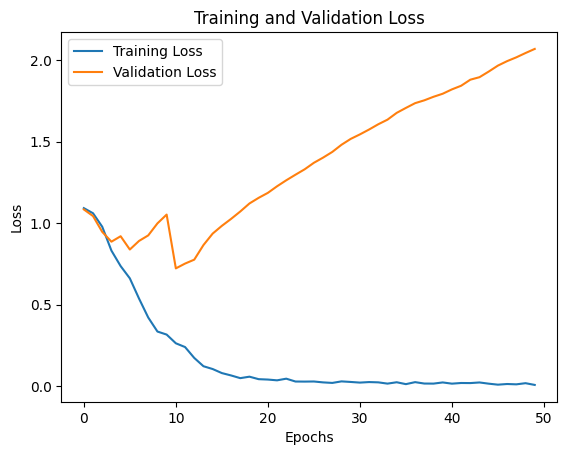

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - f1_score_macro: 0.5024 - loss: 2.4740


[2.054429769515991, 0.500740110874176]

In [31]:
plot_history(history_layer_1)

model_layer_1.evaluate(X_test.values, y_test)

#### **Variasi 2**

In [32]:
# Variasi 2 - 2 Layer LSTM
model_layer_2 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # LSTM layers for sequence modeling
            LSTM(32, return_sequences=True),
            LSTM(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_layer_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 77, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,819 (792.26 KB)

 Trainable params: 202,819 (792.26 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model_layer_2.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_layer_2 = model_layer_2.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 134ms/step - f1_score_macro: 0.4296 - loss: 1.0926 - val_f1_score_macro: 0.3333 - val_loss: 1.0580
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - f1_score_macro: 0.3872 - loss: 1.0258 - val_f1_score_macro: 0.3750 - val_loss: 0.9819
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - f1_score_macro: 0.4347 - loss: 0.9142 - val_f1_score_macro: 0.4626 - val_loss: 0.9253
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - f1_score_macro: 0.4693 - loss: 0.7689 - val_f1_score_macro: 0.4827 - val_loss: 0.8928
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - f1_score_macro: 0.4865 - loss: 0.6073 - val_f1_score_macro: 0.4597 - val_loss: 0.9745
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - f1_score_macro: 0.4903 - loss: 0.4158 - val_f1_score_macro: 0.4885 - val_loss: 0.9725
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - f1_score_macro: 0.4896 - loss: 0.3274 - val_f1_score_macro: 0.4929 - val_loss: 1.2215
Epoch 8/50
16/16 ━━━━━━━

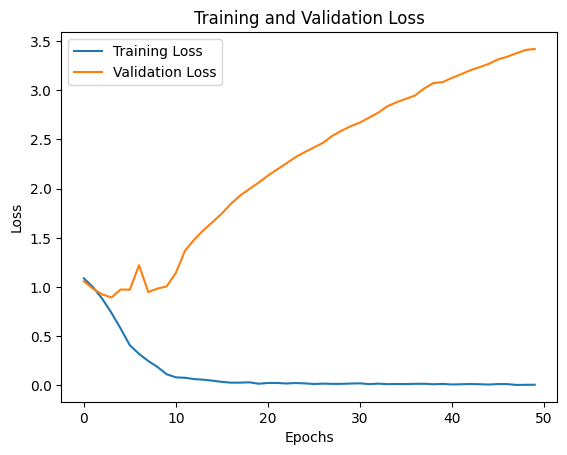

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - f1_score_macro: 0.4988 - loss: 3.4736


[3.239140033721924, 0.49729350209236145]

In [34]:
plot_history(history_layer_2)

model_layer_2.evaluate(X_test.values, y_test)

#### **Variasi 3**

In [35]:
# Variasi 3 - 3 Layer LSTM
model_layer_3 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # LSTM layers for sequence modeling
            LSTM(32, return_sequences=True),
            LSTM(32, return_sequences=True),
            LSTM(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_layer_3.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 77, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 77, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 211,139 (824.76 KB)

 Trainable params: 211,139 (824.76 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
model_layer_3.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_layer_3 = model_layer_3.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - f1_score_macro: 0.4337 - loss: 1.0975 - val_f1_score_macro: 0.4393 - val_loss: 1.0852
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step - f1_score_macro: 0.4478 - loss: 1.0735 - val_f1_score_macro: 0.4166 - val_loss: 0.9968
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - f1_score_macro: 0.4473 - loss: 0.9536 - val_f1_score_macro: 0.4543 - val_loss: 0.8961
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - f1_score_macro: 0.4758 - loss: 0.7756 - val_f1_score_macro: 0.4508 - val_loss: 0.8630
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - f1_score_macro: 0.4725 - loss: 0.6023 - val_f1_score_macro: 0.4537 - val_loss: 0.8812
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - f1_score_macro: 0.5012 - loss: 0.4642 - val_f1_score_macro: 0.4903 - val_loss: 1.0297
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - f1_score_macro: 0.4987 - loss: 0.3241 - val_f1_score_macro: 0.5037 - val_loss: 0.8807
Epoch 8/50
16/16 ━━

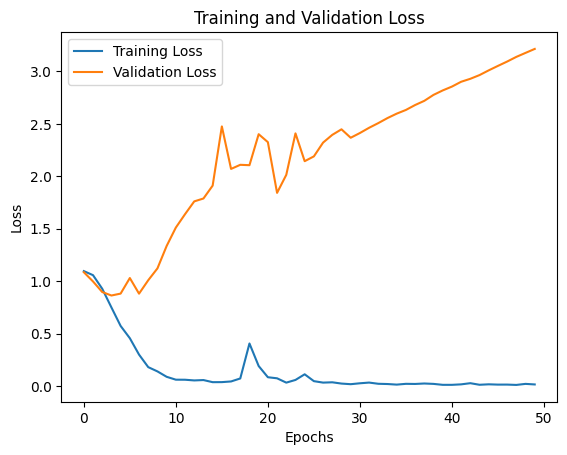

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - f1_score_macro: 0.4978 - loss: 3.2589


[3.0883731842041016, 0.49486246705055237]

In [37]:
plot_history(history_layer_3)

model_layer_3.evaluate(X_test.values, y_test)

### **Pengaruh Jumlah Cell**

#### **Variasi 1**

In [38]:
# Variasi 1
model_cell_1 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # LSTM layers for sequence modeling
            LSTM(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_cell_1.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,499 (759.76 KB)

 Trainable params: 194,499 (759.76 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model_cell_1.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_cell_1 = model_cell_1.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - f1_score_macro: 0.4826 - loss: 1.0976 - val_f1_score_macro: 0.3728 - val_loss: 1.0883
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - f1_score_macro: 0.4284 - loss: 1.0796 - val_f1_score_macro: 0.3333 - val_loss: 1.0686
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - f1_score_macro: 0.4219 - loss: 1.0552 - val_f1_score_macro: 0.3350 - val_loss: 0.9844
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - f1_score_macro: 0.4243 - loss: 0.9250 - val_f1_score_macro: 0.4506 - val_loss: 0.8767
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - f1_score_macro: 0.4703 - loss: 0.7663 - val_f1_score_macro: 0.4576 - val_loss: 0.8331
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - f1_score_macro: 0.4755 - loss: 0.6424 - val_f1_score_macro: 0.4588 - val_loss: 0.8032
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - f1_score_macro: 0.4757 - loss: 0.4959 - val_f1_score_macro: 0.4614 - val_loss: 0.7852
Epoch 8/50
16/16 ━━━━━━━━━━

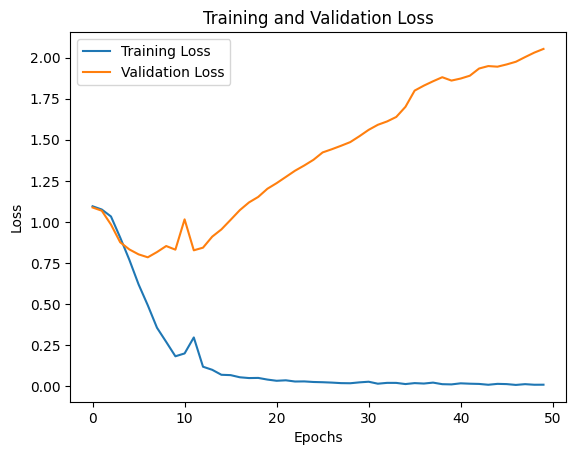

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4967 - loss: 2.3468


[2.145902395248413, 0.4925227463245392]

In [40]:
plot_history(history_cell_1)

model_cell_1.evaluate(X_test.values, y_test)

#### **Variasi 2**

In [41]:
# Variasi 2
model_cell_2 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # LSTM layers for sequence modeling
            LSTM(64),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_cell_2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,619 (842.26 KB)

 Trainable params: 215,619 (842.26 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model_cell_2.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_cell_2 = model_cell_2.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - f1_score_macro: 0.4606 - loss: 1.0955 - val_f1_score_macro: 0.3462 - val_loss: 1.0817
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - f1_score_macro: 0.4473 - loss: 1.0622 - val_f1_score_macro: 0.4496 - val_loss: 1.0202
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - f1_score_macro: 0.4303 - loss: 0.9756 - val_f1_score_macro: 0.4584 - val_loss: 0.9383
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - f1_score_macro: 0.4562 - loss: 0.7834 - val_f1_score_macro: 0.4848 - val_loss: 0.8002
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - f1_score_macro: 0.4837 - loss: 0.5098 - val_f1_score_macro: 0.4839 - val_loss: 0.7972
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - f1_score_macro: 0.4986 - loss: 0.4122 - val_f1_score_macro: 0.4849 - val_loss: 0.8357
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - f1_score_macro: 0.4952 - loss: 0.2598 - val_f1_score_macro: 0.4999 - val_loss: 0.8310
Epoch 8/50
16/16 ━━━━━━━━━

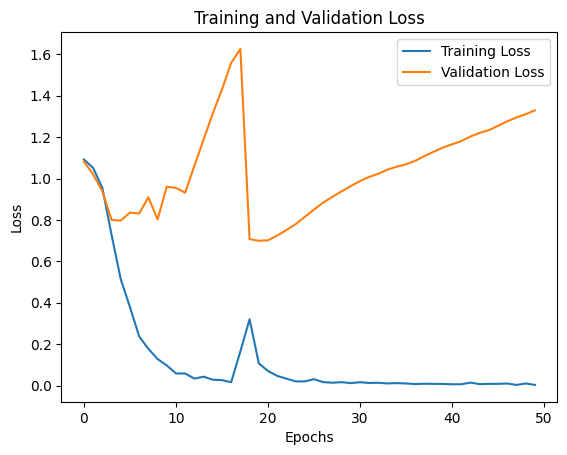

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - f1_score_macro: 0.4970 - loss: 1.6450


[1.586114764213562, 0.49539265036582947]

In [43]:
plot_history(history_cell_2)

model_cell_2.evaluate(X_test.values, y_test)

#### **Variasi 3**

In [44]:
# Variasi 3
model_cell_3 = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # LSTM layers for sequence modeling
            LSTM(128),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_cell_3.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16)             │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,435 (1.08 MB)

 Trainable params: 282,435 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model_cell_3.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_cell_3 = model_cell_3.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - f1_score_macro: 0.4159 - loss: 1.0959 - val_f1_score_macro: 0.4342 - val_loss: 1.0722
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - f1_score_macro: 0.4362 - loss: 1.0382 - val_f1_score_macro: 0.4500 - val_loss: 0.9668
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - f1_score_macro: 0.4629 - loss: 0.9465 - val_f1_score_macro: 0.4599 - val_loss: 0.8886
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - f1_score_macro: 0.4725 - loss: 0.7498 - val_f1_score_macro: 0.4508 - val_loss: 0.9539
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - f1_score_macro: 0.4542 - loss: 0.6703 - val_f1_score_macro: 0.4535 - val_loss: 1.0808
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - f1_score_macro: 0.4818 - loss: 0.6073 - val_f1_score_macro: 0.4619 - val_loss: 0.8628
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - f1_score_macro: 0.4835 - loss: 0.4699 - val_f1_score_macro: 0.4825 - val_loss: 0.9647
Epoch 8/50
16/16 ━━━

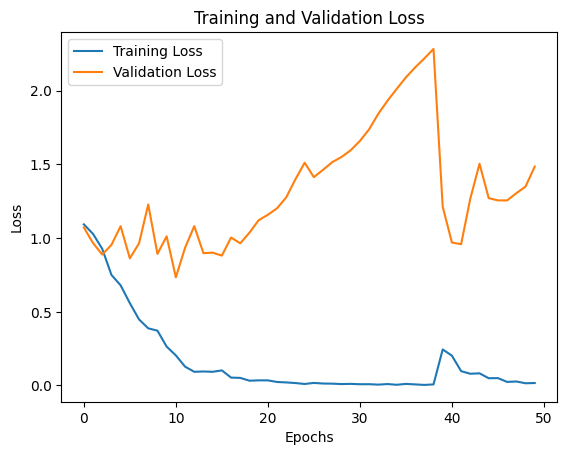

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - f1_score_macro: 0.4961 - loss: 1.8628


[1.6189063787460327, 0.4911855161190033]

In [46]:
plot_history(history_cell_3)

model_cell_3.evaluate(X_test.values, y_test)

### **Pengaruh Arah**

#### **Variasi Unidirectional**

In [47]:
# Unidirectional
model_uni = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # LSTM layers for sequence modeling
            LSTM(32),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_uni.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 194,499 (759.76 KB)

 Trainable params: 194,499 (759.76 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model_uni.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_uni = model_uni.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - f1_score_macro: 0.4714 - loss: 1.0967 - val_f1_score_macro: 0.4331 - val_loss: 1.0871
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - f1_score_macro: 0.4440 - loss: 1.0737 - val_f1_score_macro: 0.3333 - val_loss: 1.0598
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - f1_score_macro: 0.4183 - loss: 1.0002 - val_f1_score_macro: 0.3687 - val_loss: 0.9963
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - f1_score_macro: 0.4356 - loss: 0.9335 - val_f1_score_macro: 0.4295 - val_loss: 0.8935
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - f1_score_macro: 0.4581 - loss: 0.7565 - val_f1_score_macro: 0.4613 - val_loss: 0.7483
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - f1_score_macro: 0.4821 - loss: 0.5488 - val_f1_score_macro: 0.4674 - val_loss: 0.7333
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - f1_score_macro: 0.4974 - loss: 0.4147 - val_f1_score_macro: 0.4489 - val_loss: 0.8194
Epoch 8/50
16/16 ━━━━━━━━━━

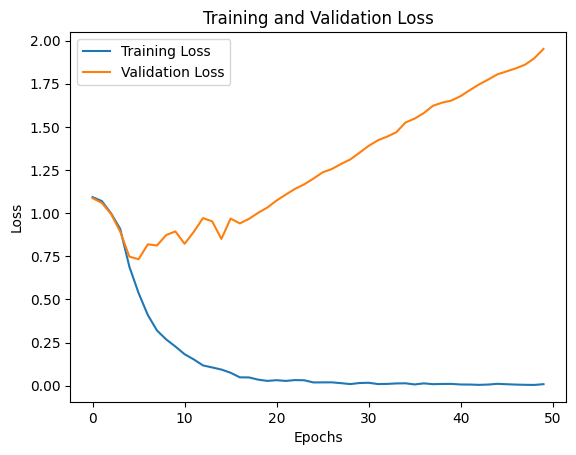

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1_score_macro: 0.4987 - loss: 2.2069


[2.042081356048584, 0.496213436126709]

In [49]:
plot_history(history_uni)

model_uni.evaluate(X_test.values, y_test)

#### **Variasi Bidirectional**

In [50]:
# Bidirectional
model_bi = Sequential([
            Input(shape=(), dtype=tf.string),
            vectorize_layer,

            Embedding(
                input_dim=len(vectorize_layer.get_vocabulary()),
                output_dim=64,
                mask_zero=True
            ),

            # LSTM layers for sequence modeling
            Bidirectional(LSTM(32)),

            # Dense layers
            Dropout(0.5),
            Dense(16, activation='relu'),
            Dropout(0.3),
            Dense(3, activation='softmax')
        ])

model_bi.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 77)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 207,427 (810.26 KB)

 Trainable params: 207,427 (810.26 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
model_bi.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_bi = model_bi.fit(X_train.values, y_train, epochs=50, validation_data=(X_valid.values, y_valid), callbacks=[early_stopping_callback])

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - f1_score_macro: 0.4715 - loss: 1.0963 - val_f1_score_macro: 0.3333 - val_loss: 1.0838
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - f1_score_macro: 0.3699 - loss: 1.0666 - val_f1_score_macro: 0.3333 - val_loss: 1.0585
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - f1_score_macro: 0.4363 - loss: 1.0248 - val_f1_score_macro: 0.4557 - val_loss: 0.9760
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - f1_score_macro: 0.4527 - loss: 0.8450 - val_f1_score_macro: 0.4640 - val_loss: 0.8304
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - f1_score_macro: 0.4869 - loss: 0.5546 - val_f1_score_macro: 0.5009 - val_loss: 0.8027
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - f1_score_macro: 0.4924 - loss: 0.3056 - val_f1_score_macro: 0.5034 - val_loss: 0.7969
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - f1_score_macro: 0.4979 - loss: 0.1784 - val_f1_score_macro: 0.4973 - val_loss: 0.8451
Epoch 8/50
16/16 ━━━━━━━━

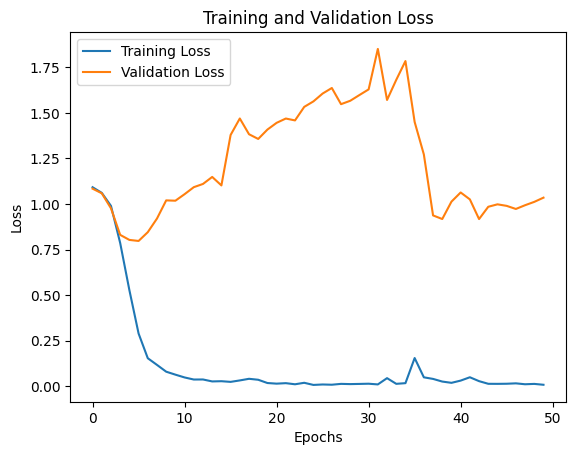

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - f1_score_macro: 0.4949 - loss: 1.7403


[1.5837488174438477, 0.4880656898021698]

In [52]:
plot_history(history_bi)

model_bi.evaluate(X_test.values, y_test)

## **Perbandingan dengan model from _scratch_**

In [53]:
config = vectorize_layer.get_config()
sequence_length_from_config = config['output_sequence_length']

print(sequence_length_from_config)

77


In [54]:
vectorized_train_text = vectorize_layer(X_train)
vectorized_valid_text = vectorize_layer(X_valid)
vectorized_test_text = vectorize_layer(X_test)

In [55]:
model_keras = Sequential([
          Embedding(
              input_dim=len(vectorize_layer.get_vocabulary()),
              output_dim=64,
              mask_zero=True
          ),

          # RNN layers for sequence modeling
          Bidirectional(LSTM(32)),

          # Dense layers
          Dropout(0.5),
          Dense(16, activation='relu'),
          Dropout(0.3),
          Dense(3, activation='softmax')
      ])

In [56]:
model_keras.compile(loss=SparseCategoricalCrossentropy(), optimizer=Adam(), metrics=[F1Score(average="macro", name="f1_score_macro")])

history_keras = model_keras.fit(vectorized_train_text, y_train, epochs=50, validation_data=(vectorized_valid_text, y_valid), callbacks=[early_stopping_callback])
model_keras.summary()
model_keras.save("keras_model.h5")

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - f1_score_macro: 0.4743 - loss: 1.0962 - val_f1_score_macro: 0.3802 - val_loss: 1.0867
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - f1_score_macro: 0.4416 - loss: 1.0728 - val_f1_score_macro: 0.4528 - val_loss: 1.0576
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - f1_score_macro: 0.4411 - loss: 1.0081 - val_f1_score_macro: 0.4417 - val_loss: 0.9388
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - f1_score_macro: 0.4576 - loss: 0.8134 - val_f1_score_macro: 0.4554 - val_loss: 0.8453
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - f1_score_macro: 0.4668 - loss: 0.6180 - val_f1_score_macro: 0.4597 - val_loss: 0.8020
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - f1_score_macro: 0.4924 - loss: 0.4486 - val_f1_score_macro: 0.4856 - val_loss: 0.7491
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - f1_score_macro: 0.4968 - loss: 0.2952 - val_f1_score_macro: 0.5067 - val_loss: 0.7831
Epoch 8/50
16/16 ━━━━━━━

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ (None, 77, 64)         │       181,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 622,283 (2.37 MB)

 Trainable params: 207,427 (810.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 414,856 (1.58 MB)

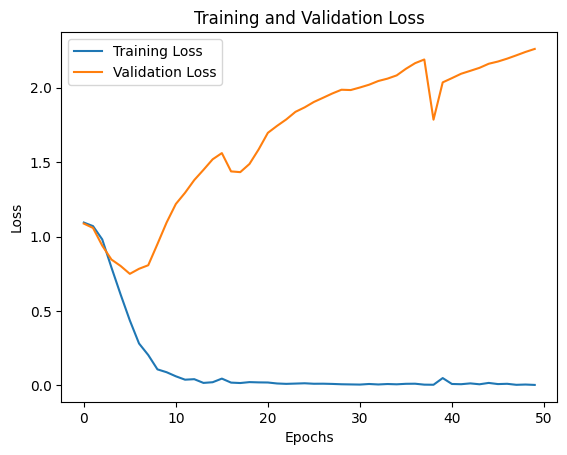

In [57]:
plot_history(history_keras)

In [58]:
keras_loss, keras_f1_macro = model_keras.evaluate(vectorized_test_text, y_test, verbose=0)
print(f"Keras Test Loss: {keras_loss:.4f}")
print(f"Keras Test F1-score (macro): {keras_f1_macro:.4f}")

Keras Test Loss: 2.2757
Keras Test F1-score (macro): 0.4940


In [63]:
from lstm_layer import *

model_custom = Model_c([
    Embedding_c(input_dim=len(vectorize_layer.get_vocabulary()), output_dim=64),
    Bidirectional_c(LSTM_c(units=32, input_size=64)),
    Dropout_c(0.5),
    Dense_c(16, input_size=64, activation_function='relu'),
    Dropout_c(0.3),
    Dense_c(3, input_size=16, activation_function='softmax')
])

In [64]:
model_custom.load_weights_from_keras_model('keras_model.h5')

In [65]:
keras_output = model_keras.predict(vectorized_test_text)
custom_output = model_custom.predict(vectorized_test_text)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


AttributeError: 'LSTM_c' object has no attribute 'h_0'

In [ ]:
print("\nSampel Output Mentah (5 sampel pertama):")
for i in range(min(5, len(keras_output))):
    print(f"Sampel {i+1}:")
    print(f"  Keras : {keras_output[i]}")
    print(f"  Custom: {custom_output[i]}")
    print("-" * 20)

In [ ]:
abs_diff = np.mean(np.abs(keras_output - custom_output))
print(f"Perbedaan absolut rata-rata antara output Keras dan Custom: {abs_diff:.6f}")

In [ ]:
print(f"F1-score Macro Model Keras: {keras_f1_macro:.4f}")

y_pred_custom_labels = np.argmax(custom_output, axis=1)

custom_f1_macro = f1_score(y_test, y_pred_custom_labels, average='macro')
print(f"F1-score Macro Model Custom: {custom_f1_macro:.4f}")

print("\nPerbandingan F1-score Macro:")
print(f"  Keras : {keras_f1_macro:.4f}")
print(f"  Custom: {custom_f1_macro:.4f}")

print("\nLaporan Klasifikasi Model Custom:")
report_custom = classification_report(y_test.values, y_pred_custom_labels, target_names=label_map.keys())
print(report_custom)

y_pred_keras_labels = np.argmax(keras_output, axis=1)
keras_f1_macro_from_predict = f1_score(y_test, y_pred_keras_labels, average='macro')
print(f"\nF1-score Macro Model Keras (dari predict, untuk perbandingan langsung): {keras_f1_macro_from_predict:.4f}")
print("\nLaporan Klasifikasi Model Keras (dari predict):")
report_keras_predict = classification_report(y_test.values, y_pred_keras_labels, target_names=label_map.keys())
print(report_keras_predict)